# THIS FILE IS IN THE HANDOUTS FOLDER. COPY IT INTO YOUR CLASS NOTES

- [**Read the chapter on the website!**](https://ledatascifi.github.io/ledatascifi-2022/content/05/02_reg.html) It contains a lot of extra information we won't cover in class extensively.
- After reading that, I recommend [this webpage as a complimentary place to get additional intuition.](https://aeturrell.github.io/coding-for-economists/econmt-regression.html)

## ASAP

[Declare your team and project interests in the project sheet](https://docs.google.com/spreadsheets/d/1A6oQfhTBHHEb_EWSgfQv2KgsBoZm4V_BQWuvTjxnrdo/edit#gid=1508330834)


# Today: Regression

We start our machine learning applications with regression for a few simple reasons:

- Regression is fundamental method for estimating the relationship between a variable ("y") that condition on many ("X") variables. 
- But the coefficients obtained can also be used to generate predictions. 
- _Note: The focus in this section is on RELATIONSHIP paradigm_
- Many issues that confront researchers have well understood solutions when regression is the model being used. 
- Regression coefficients are easy to interpret.

  
## Objectives

1. You can fit a regression with `statsmodels` or `sklearn`
    - statsmodels: Nicer result tables, usually easier to specifying the regression model
    - sklearn: Easier to use within a prediction/ML exercise
2. You can view the results visually or numerically of your model with either method
3. The focus today is on the _mechanics_ of running regressions, viewing the output, and using the estimation's output objects.

![](https://media.giphy.com/media/yoJC2K6rCzwNY2EngA/giphy.gif)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols as sm_ols
import matplotlib.pyplot as plt


## Data

First, we load the data. 

**This is a new dataset, so we should do some data exploration!** Things students should try:
- describe() - any impossible values
- value_count() any categorical variables
- didn't we have a community function to start the EDA?
- correlation heat map
- look for outliers for all variables, and within pairplots
- print out and explore many sections of the data manually (in Excel or Spyder) to get familiar and check for data consistency issues


In [2]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2022/blob/main/data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip') 

## Task 1

Spend 5 minutes exploring the data and jot down what you learn about the data. 


In [17]:
fannie_mae.describe()
fannie_mae.head().T

,0,1,2,3,4
Loan_Identifier,973373000000.0,927620000000.0,717667000000.0,988951000000.0,190885000000.0
Origination_Channel,B,B,B,C,R
Seller_Name,OTHER,"PNC BANK, N.A.",OTHER,AMTRUST BANK,OTHER
Original_Interest_Rate,6.875,5.875,6.25,6.0,5.875
Original_UPB,32000.0,200000.0,122000.0,67000.0,50000.0
Original_Loan_Term,360.0,360.0,180.0,180.0,180.0
Original_LTV_(OLTV),90.0,80.0,80.0,77.0,41.0
Original_Combined_LTV_(CLTV),90.0,80.0,80.0,77.0,41.0
Number_of_Borrowers,1.0,2.0,2.0,2.0,2.0
Original_Debt_to_Income_Ratio,22.0,26.0,31.0,17.0,10.0


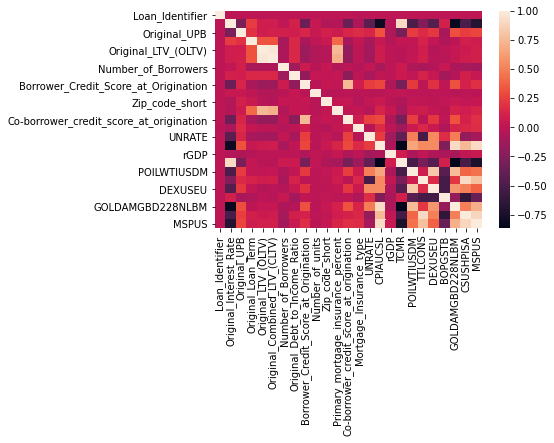

In [13]:
fannie_mae.Loan_Identifier.value_counts()

sns.heatmap(fannie_mae.corr());

## Clean the data and create variables we will use

These variables are pretty straightforward:

In [18]:
fannie_mae = (fannie_mae
                  # create variables
                  .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                          l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                          Origination_Date = lambda x: pd.to_datetime(x['Origination_Date']),
                          Origination_Year = lambda x: x['Origination_Date'].dt.year,
                          const = 1,
                          great = fannie_mae['Borrower_Credit_Score_at_Origination'] >= 800
                         )
              
             )

Credit rating is a number between 0 and 850. But in some analysis, it might make sense to have categories of credit ratings (e.g. bad to good). I borrowed [these cutoffs from experian.](https://www.experian.com/blogs/ask-experian/infographic-what-are-the-different-scoring-ranges/)

In [19]:
# create a categorical bin var with "pd.cut()"

fannie_mae['creditbins']= pd.cut(fannie_mae['Borrower_Credit_Score_at_Origination'],
                                 [0,579,669,739,799,850],
                                 labels=['Very Poor','Fair','Good','Very Good','Exceptional'])

Here is the variable that created. I notice that 669 (right on the threshold of a bin) goes into the "Fair" bin instead of "Good".

In [20]:
fannie_mae.loc[:5,['Borrower_Credit_Score_at_Origination','creditbins']]

,Borrower_Credit_Score_at_Origination,creditbins
0,669.0,Fair
1,693.0,Good
2,741.0,Very Good
3,804.0,Exceptional
4,658.0,Fair
5,665.0,Fair


In [21]:
# pd.cut took credit , var number between 0 and 850,
# and changed it to bins. I labeled the bins explicitly

fannie_mae['creditbins'].value_counts(dropna=False)

Very Good      63855
Good           39539
Exceptional    15889
Fair           14560
Very Poor        638
NaN              557
Name: creditbins, dtype: int64

## Exercises with statsmodels

- **For all problems: y is the interest rate of the loan**
- I recommend the _statsmodels formula_ method on the website

Psuedocode for using statsmodels to run a regression:
```python
model = sm_ols(<formula>, data=<dataframe>)
result=model.fit()

# to print regression output: result.summary()
# get predicted values (yhat): result.predict
# get regression residuals (uhat): result.resid
```

### Q1: Starter regressions

A. Regress y on the credit score (student demo): $y=\beta_0 + \beta_1*\text{Credit Score}$
- _I'll show 2 ways: the psuedo code and the one-liner_

B. Regress y on the **natural log** of the credit score: $y=\beta_0 + \beta_1*log(\text{Credit Score})$
- _I'll show two ways to do this_

C. Regress y on the **natural log** of the loan-to-value

D. Regress y on the natural log of the loan-to-value and the natural log of the credit score: $y=\beta_0 + \beta_1*log(\text{LTV}) + \beta_2*log(\text{Credit Score})$

In [27]:
#A
#Option A, declare model, save reults, use results
model = sm_ols('Original_Interest_Rate ~ Borrower_Credit_Score_at_Origination', data = fannie_mae)

results = model.fit()
results.summary()

#option b, dont save model or results, just print 
sm_ols('Original_Interest_Rate ~ Borrower_Credit_Score_at_Origination', data = fannie_mae).fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.126
Model:                                OLS   Adj. R-squared:                  0.126
Method:                     Least Squares   F-statistic:                 1.938e+04
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:22:37   Log-Likelihood:            -2.1575e+05
No. Observations:                  134481   AIC:                         4.315e+05
Df Residuals:                      134479   BIC:                         4.315e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               11.5819      0.046    253.270      0.000      11.492      11.671
Borrower_Credit_Score_at_Origination    -0.0086   6.14e-05   -139.198      0.000      -0.009      -0.008
==============================================================================
Omnibus:                     2660.479   Durbin-Watson:                   0.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2660.737
Skew:                           0.321   Prob(JB):                         0.00
Kurtosis:                       2.750   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
#B reg on log credit score 
#option 1 create var ahead of time and use it 
sm_ols('Original_Interest_Rate ~ l_credscore', data = fannie_mae).fit().summary()

#option 2 
sm_ols('Original_Interest_Rate ~ np.log(Borrower_Credit_Score_at_Origination)', data = fannie_mae).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.124
Model:                                OLS   Adj. R-squared:                  0.124
Method:                     Least Squares   F-statistic:                 1.906e+04
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:28:45   Log-Likelihood:            -2.1589e+05
No. Observations:                  134481   AIC:                         4.318e+05
Df Residuals:                      134479   BIC:                         4.318e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       45.3715      0.291    156.057      0.000      44.802      45.941
np.log(Borrower_Credit_Score_at_Origination)    -6.0750      0.044   -138.067      0.000      -6.161      -5.989
==============================================================================
Omnibus:                     2741.277   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2737.156
Skew:                           0.325   Prob(JB):                         0.00
Kurtosis:                       2.744   Cond. No.                         598.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#C natural log of loan to value 
#Q("bad var name")
sm_ols('Original_Interest_Rate ~ np.log(Q("Original_LTV_(OLTV)"))', data = fannie_mae).fit().summary()
#using previously made data
sm_ols('Original_Interest_Rate ~ l_LTV', data = fannie_mae).fit().summary()
#Original_LTV_(OLTV)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     1010.
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):          8.41e-221
Time:                            11:35:58   Log-Likelihood:            -2.2548e+05
No. Observations:                  135038   AIC:                         4.510e+05
Df Residuals:                      135036   BIC:                         4.510e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7603      0.047     80.622      0.000       3.669       3.852
l_LTV          0.3513      0.011     31.779      0.000       0.330       0.373
==============================================================================
Omnibus:                     4889.290   Durbin-Watson:                   0.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3115.913
Skew:                           0.245   Prob(JB):                         0.00
Kurtosis:                       2.439   Cond. No.                         59.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
#D
sm_ols('Original_Interest_Rate ~ l_LTV+l_credscore', data = fannie_mae).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.126
Model:                                OLS   Adj. R-squared:                  0.126
Method:                     Least Squares   F-statistic:                     9656.
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:51:49   Log-Likelihood:            -2.1578e+05
No. Observations:                  134481   AIC:                         4.316e+05
Df Residuals:                      134478   BIC:                         4.316e+05
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      44.1324      0.302    145.949      0.000      43.540      44.725
l_LTV           0.1546      0.010     14.765      0.000       0.134       0.175
l_credscore    -5.9859      0.044   -134.888      0.000      -6.073      -5.899
==============================================================================
Omnibus:                     2793.369   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2743.990
Skew:                           0.321   Prob(JB):                         0.00
Kurtosis:                       2.720   Cond. No.                         735.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q2: Best practices: Look at the outputs every time

Let's talk about the outputs you see and should look at EVERY time you run a regression:
- Number of obs
- R2 
- AR2
- Coef 
- Std error, t value, p value ("P>|t|")
- Std error options:
    - `.fit(cov_type="HC2")`
    - `.fit(cov_type="cluster", cov_kwds={"groups": df["industry"]})`

### Q3: Regressions with transformations

We are talking about "linear regression. What that means is that the model is linear in the regressors: but it doesn’t mean that those regressors can't be some kind of non-linear transform of the original features $x_i$." The most common transformations are logging variables, interaction terms, and polynomial terms."

We already did log transformations above. 

An interaction term simply means one regressor is two variables multiplied:
- $y=\beta_0 + \beta_1 x_1 + \beta_2 x_1 x_2$
- $y=\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 $

Polynomial terms might look like:
- $y=\beta_0 + \beta_1 x_1 + \beta_2 x_1^2$

A. Regress y on the credit score and the credit score squared.

In [50]:
#use pow, np.square or np.power
sm_ols('Original_Interest_Rate ~ Borrower_Credit_Score_at_Origination+ np.square(Borrower_Credit_Score_at_Origination)'
       , data = fannie_mae).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.128
Model:                                OLS   Adj. R-squared:                  0.128
Method:                     Least Squares   F-statistic:                     9880.
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:49:57   Log-Likelihood:            -2.1558e+05
No. Observations:                  134481   AIC:                         4.312e+05
Df Residuals:                      134478   BIC:                         4.312e+05
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           2.8016      0.481      5.822      0.000       1.858       3.745
Borrower_Credit_Score_at_Origination                0.0160      0.001     11.930      0.000       0.013       0.019
np.square(Borrower_Credit_Score_at_Origination) -1.704e-05    9.3e-07    -18.329      0.000   -1.89e-05   -1.52e-05
==============================================================================
Omnibus:                     2433.505   Durbin-Watson:                   0.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2428.353
Skew:                           0.306   Prob(JB):                         0.00
Kurtosis:                       2.759   Cond. No.                     8.21e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.21e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 

B. Regress y on the natural log of the loan-to-value, the natural log of the credit score, and the interaction of LTV and credit score. 

### Q4: Dummy and categorical variables

A. Regress y on the dummy variable for a great credit score.

B. Regress y on the categorical variable we created for credit bins.

C. (Advanced, optional, after class exercise): High dimensional fixed effects. This basically means "a categorical variable with LOTS of values". [See this discussion.](https://aeturrell.github.io/coding-for-economists/econmt-regression.html#high-dimensional-fixed-effects-aka-absorbing-regression)

In [53]:
#A binary dummy vars can just be added 
sm_ols('Original_Interest_Rate ~ great', data = fannie_mae).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.050
Model:                                OLS   Adj. R-squared:                  0.050
Method:                     Least Squares   F-statistic:                     7048.
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:52:00   Log-Likelihood:            -2.2255e+05
No. Observations:                  135038   AIC:                         4.451e+05
Df Residuals:                      135036   BIC:                         4.451e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.3433      0.004   1466.712      0.000       5.336       5.350
great[T.True]    -0.8916      0.011    -83.951      0.000      -0.912      -0.871
==============================================================================
Omnibus:                     2948.608   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2309.413
Skew:                           0.239   Prob(JB):                         0.00
Kurtosis:                       2.572   Cond. No.                         3.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#you can add categoriacla bariables into a reg
# you will get one coef for each level of var, minus 1
# ALWAYS put a categorical variable inside C()
sm_ols('Original_Interest_Rate ~ C(creditbins)', data = fannie_mae).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Original_Interest_Rate   R-squared:                       0.116
Model:                                OLS   Adj. R-squared:                  0.116
Method:                     Least Squares   F-statistic:                     4411.
Date:                    Wed, 23 Mar 2022   Prob (F-statistic):               0.00
Time:                            11:54:25   Log-Likelihood:            -2.1651e+05
No. Observations:                  134481   AIC:                         4.330e+05
Df Residuals:                      134476   BIC:                         4.331e+05
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.7172      0.048    140.160      0.000       6.623       6.811
C(creditbins)[T.Fair]           -0.6749      0.049    -13.784      0.000      -0.771      -0.579
C(creditbins)[T.Good]           -1.2020      0.048    -24.881      0.000      -1.297      -1.107
C(creditbins)[T.Very Good]      -1.6642      0.048    -34.552      0.000      -1.759      -1.570
C(creditbins)[T.Exceptional]    -2.2655      0.049    -46.351      0.000      -2.361      -2.170
==============================================================================
Omnibus:                     2410.734   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2345.942
Skew:                           0.294   Prob(JB):                         0.00
Kurtosis:                       2.729   Cond. No.                         37.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q5: Summarize what you've learned so far


### Q6: Plot the regression

_If time is tight: I'll do it._

Plot 1:
- Plot a scatterplot: Plot as X the credit score variable. As Y, use our y.
- On top of that, lineplots:
    - Rerun Q1a's reg and plot the yhat values. 
    - Let's talk about this.
    - Rerun Q1b's reg and plot the yhat values.
    - Compare to the prior line.
    
Plot 2:
- Plot a scatterplot: Plot as X the credit score variable. As Y, use our y.
- On top of that, lineplots:
    - Rerun Q4b's reg and plot the yhat values, hued by credit bin
  
Plot 3:
- Plot a scatterplot: Plot as X the credit score variable. As Y, use our y.
- On top of that, lineplots:
    - Rerun Q4b's reg BUT WITH credit score as a variable and plot the yhat values, hued by credit bin  
    
_Note: statsmodels has some useful plotting functions. My favs are influence_plot (can be slow) and plot_partregress_grid._

## Regression with SKLEARN

I don't like running regressions in `sklearn` usually. The main reason to do so is if you're doing a typical ML task that sklearn excels in (meaning: "pipelines", which is a term you'll understand later in the course) or if you know you're going to be using other sklearn models anyways (in which case, you'll already be doing the set up for sklearn).

But I want to run at least one regression in SKLEARN for you so you can see how the mechanics are similar, and how they differ. We will cover sklearn more in future classes.

Psuedocode for a reg in sklearn is similar. The differences:
1. A little more work setting up the data
1. `.fit()` gets the data passed to it 
1. The `results` object is different than statsmodels'

```python

# 1. import the "class" of model form sklearn

from sklearn.linear_model import LinearRegression

# 2. arrange the data - more work than statsmodels

# Issue: sklearn doesn't work with missing values, so drop any obs with missing values
# replace vars_in_your_reg with a list of variables you want to use, including y
subset = df[vars_in_your_reg].dropna()

# explicitly set up the y variable and the X variables you want
y = subset['y'] # whatever the y variable is
X = subset[['X1','X2']] # list the X vars

# 3. set up the model ("instantiate the model")
# every class of models has "hyperparamaters" that control how you want the model to work
# below, fit_intercept=True is a "hyperparameter" for OLS models 
# hyperparameters are the things inside the parenthesis of the model class when you declare it

model = LinearRegression(fit_intercept=True)
result=model.fit(X,y) # in sklearn, you put X and Y inside fit!!!

# the result object is different in sklearn
# results.intercept_ (the constant in the model)
# results.coef_ (the other X vars)

```


## Q7: STUDENT DEMO - regressions **using sklearn**

A. Regress the interest rate on the natural log of the loan-to-value using the sklearn method.

B. Regress the interest rate on the natural log of the loan-to-value using the sklearn method.